### AAI-530 IoT Based Smart Parking - Occupancy Status Prediction using **LSTM**

In [3]:
# import necessary python libraries
import pandas as pd
import numpy as np

In [4]:
# Load the original real-time Smart Parking Management dataset 
df = pd.read_csv("IIoT_Smart_Parking_Management.csv")

In [5]:
df

,Timestamp,Parking_Spot_ID,Sensor_Reading_Proximity,Sensor_Reading_Pressure,Vehicle_Type_Weight,Vehicle_Type_Height,User_Type,Weather_Temperature,Weather_Precipitation,Nearby_Traffic_Level,...,Occupancy_Status,Vehicle_Type,Parking_Violation,Sensor_Reading_Ultrasonic,Parking_Duration,Environmental_Noise_Level,Dynamic_Pricing_Factor,Spot_Size,Proximity_To_Exit,User_Parking_History
0,2021-01-01 00:00:00.000000000,20,1.023651,1.541461,1831.770127,4.392528,Visitor,18.092553,1,Low,...,Occupied,Car,0,102.951052,4,55.620740,0.8,Standard,6.610474,6.660310
1,2021-01-02 06:39:16.756756756,49,3.903349,1.621719,1330.815754,4.595638,Registered,13.397533,0,Low,...,Occupied,Car,0,87.559131,3,56.682386,1.2,Compact,8.678719,6.766187
2,2021-01-03 13:18:33.513513513,38,10.315709,6.292374,1255.134827,4.313721,Registered,21.687410,0,High,...,Vacant,Car,1,100.061854,5,59.239322,0.8,Standard,13.795262,-0.910052
3,2021-01-04 19:57:50.270270270,31,6.588039,1.659870,1523.442919,3.567329,Visitor,18.683461,0,Medium,...,Vacant,Motorcycle,1,110.594598,2,44.545155,0.8,Standard,1.678721,10.415888
4,2021-01-06 02:37:07.027027027,8,8.213969,3.278467,1758.490837,5.145836,Visitor,19.214876,0,High,...,Occupied,Car,0,84.786963,2,48.012604,0.8,Standard,20.012252,4.355544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2024-06-24 21:22:52.972972960,5,5.349471,10.515457,1267.050258,4.442869,Visitor,19.430937,0,Low,...,Vacant,Car,0,105.332652,2,69.507857,0.8,Oversized,3.686763,1.749779
996,2024-06-26 04:02:09.729729728,47,15.688164,2.661805,1547.138376,4.413585,Visitor,25.426111,0,Low,...,Vacant,Car,1,124.841337,2,49.958346,1.5,Standard,11.989485,2.569270
997,2024-06-27 10:41:26.486486480,7,0.357255,1.411642,1552.856947,4.380228,Registered,20.192776,0,Low,...,Vacant,Car,0,93.011015,1,60.676107,1.0,Standard,4.265255,11.013160
998,2024-06-28 17:20:43.243243232,49,0.293735,12.630766,1299.945385,4.091230,Registered,17.581707,0,Medium,...,Occupied,Car,1,89.972326,2,56.465611,1.2,Oversized,5.713190,4.561407


### **LSTM** for Parking Occupancy Status Prediction on Original Dataset **(Without Feature Engineering)**

In [6]:
# import necessary python libraries
import pandas as pd
import numpy as np

# import sklearn for preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# import tensorflow for using with LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# import matplotlib for visualization
import matplotlib.pyplot as plt

# Load the original real-time IoT Smart Parking dataset
df = pd.read_csv("IIoT_Smart_Parking_Management.csv")

# Convert the timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Encode categorical columns with one-hot encoding for better performance with LSTM
df = pd.get_dummies(df, columns=['User_Type', 'Nearby_Traffic_Level', 'Parking_Lot_Section', 
                                 'Payment_Status', 'Vehicle_Type', 'Spot_Size'])

# Encode the 'Occupancy_Status' column into numerical format
df['Occupancy_Status'] = df['Occupancy_Status'].apply(lambda x: 1 if x == 'Occupied' else 0)

# Compute the correlation matrix, including 'Occupancy_Status'
correlation_matrix = df.corr()

# Find correlation with the target ('Occupancy_Status') separately
correlation_with_occupancy = correlation_matrix['Occupancy_Status'].abs().sort_values(ascending=False)

# Check the correlation values of all features with 'Occupancy_Status'
print("Correlation with Occupancy_Status: \n", correlation_with_occupancy)

# Select features with correlation > 0.04 (you can adjust this threshold)
highly_correlated_features = correlation_with_occupancy[correlation_with_occupancy > 0.04].index.tolist()

# If 'Occupancy_Status' itself is in the list, remove it
highly_correlated_features.remove('Occupancy_Status')

# Check what features were selected
print("Highly Correlated Features: ", highly_correlated_features)



Correlation with Occupancy_Status: 
 Occupancy_Status                 1.000000
Occupancy_Rate                   0.063943
Parking_Lot_Section_Zone C       0.062415
Environmental_Noise_Level        0.060882
Parking_Spot_ID                  0.051377
Vehicle_Type_Electric Vehicle    0.050817
Nearby_Traffic_Level_High        0.043693
User_Parking_History             0.039441
Sensor_Reading_Proximity         0.037237
User_Type_Visitor                0.036741
Sensor_Reading_Ultrasonic        0.036265
User_Type_Staff                  0.035445
Spot_Size_Compact                0.033674
Parking_Lot_Section_Zone A       0.032682
Dynamic_Pricing_Factor           0.032043
Vehicle_Type_Car                 0.029943
Timestamp                        0.027086
Parking_Duration                 0.026814
Exit_Time                        0.024956
Nearby_Traffic_Level_Medium      0.023401
Parking_Lot_Section_Zone B       0.022443
Vehicle_Type_Weight              0.021822
Vehicle_Type_Height              0.0209

### The above output shows the correlation of other fields w.r.t Occupancy Status.
### The top highly correlated features could be considered as features to be used for prediction

In [7]:
# If there are no highly correlated features left, issue a warning
if len(highly_correlated_features) == 0:
    print("Warning: No features have high enough correlation. Consider lowering the correlation threshold.")
else:
    # Subset the dataframe with the selected highly correlated features
    df = df[highly_correlated_features + ['Occupancy_Status']]  # Add 'Occupancy_Status' back for target

    # Now, prepare features (X) and target (y)
    X = df.drop('Occupancy_Status', axis=1).values
    y = df['Occupancy_Status'].values

    # Verify if the feature set (X) has any valid columns
    print(f"Shape of X before scaling: {X.shape}")

    # Proceed with scaling if X has features
    if X.shape[1] > 0:
        # Use MinMaxScaler for normalization
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)

        # Prepare the data for time series (sequence data for LSTM)
        sequence_length = 5  # Predict for the next 5 days

        # Function to create sequences
        def create_sequences(X, y, seq_length):
            X_seq, y_seq = [], []
            for i in range(len(X) - seq_length):
                X_seq.append(X[i:i + seq_length])
                y_seq.append(y[i + seq_length])
            return np.array(X_seq), np.array(y_seq)

        X_seq, y_seq = create_sequences(X_scaled, y, sequence_length)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True)

        # Build and train the LSTM model
        from tensorflow.keras.layers import Input

        # Build and train the LSTM model
        model = Sequential()

        # Add multiple LSTM layers with different numbers of units
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input shape for time-series data
        
        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.3))  # Dropout layer to prevent overfitting
        
        model.add(LSTM(units=128, return_sequences=True))
        model.add(Dropout(0.3))  # Dropout layer to prevent overfitting
        
        model.add(LSTM(units=64, return_sequences=True))
        model.add(Dropout(0.3))  # Dropout layer to prevent overfitting
        
        model.add(LSTM(units=64, return_sequences=False))  # The final LSTM layer
        # Add Dropout layer to prevent overfitting
        model.add(Dropout(0.3))
        
        model.add(Dense(units=1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))  # Increased epochs
      
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Accuracy: {accuracy * 100:.2f}%')
    else:
        print("Error: The feature set has no valid features after correlation filtering.")


Shape of X before scaling: (1000, 6)
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.5086 - loss: 0.6926 - val_accuracy: 0.5980 - val_loss: 0.6879
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5473 - loss: 0.6907 - val_accuracy: 0.5980 - val_loss: 0.6832
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5605 - loss: 0.6876 - val_accuracy: 0.5980 - val_loss: 0.6851
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5407 - loss: 0.6912 - val_accuracy: 0.5980 - val_loss: 0.6842
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5548 - loss: 0.6888 - val_accuracy: 0.5980 - val_loss: 0.6830
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5498 - loss: 0.6890 - val_accuracy: 0.5980 - val_loss: 0.6852
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5334 - loss: 0.6911 - val_accuracy: 0.5980 - val_loss: 0.6840
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.

### As can be seen above a training accuracy of about 81% is achieved but the validation accuracy is 58.79%
### for sequence length 5 (5 Day) prediction

In [17]:
# Print model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 1, 128)              │          89,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,685 (1.59 MB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,124 (1.06 MB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


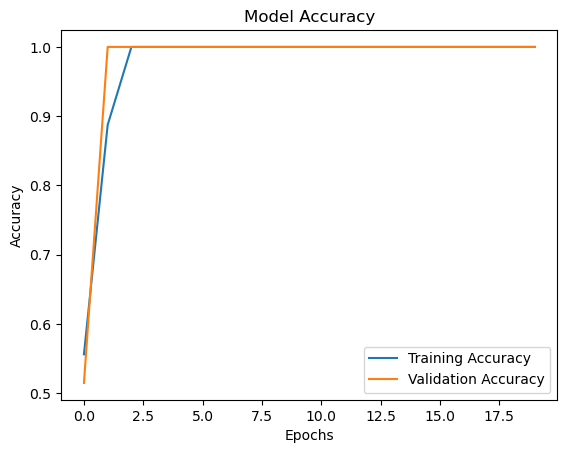

In [20]:
# Predict the occupancy status for the next 5 days
predictions = model.predict(X_test)

# Convert predictions back to Occupancy_Status
predicted_occupancy = ['Occupied' if pred > 0.5 else 'Vacant' for pred in predictions]

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### **LSTM** for predicting Parking Occupancy Status for 1 sequence step on **Feature Engineered** Dataset

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder # Import LabelEncoder here
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load the feature engineering dataset
# Refer to IoT_SmartParking_Feature_Engg.ipynb for the feature engineering
df = pd.read_csv('IoT_SmartParking_Processed.csv')

# Inspect the data
print(df.head())

# Preprocessing
# Occupancy_Status is the target variable and other columns are features
target_column = 'Occupancy_Status'
features = [col for col in df.columns if col != target_column and col != 'Timestamp' and df[col].dtype != object]

X = df[features].values
y = df[target_column].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode target variable to numeric using LabelEncoder
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Reshape input for LSTM (samples, timesteps, features)
timesteps = 1  # Can be adjusted based on sequence dependency
X_reshaped = X_scaled.reshape((X_scaled.shape[0], timesteps, X_scaled.shape[1]))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Input
# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Increased units
model.add(Dropout(0.2))  # Increased dropout to reduce overfitting
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))  # Increased dropout
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


                       Timestamp  Parking_Spot_ID  Sensor_Reading_Proximity  \
0  2021-01-01 00:00:00.000000000               20                  1.023651   
1  2021-01-02 06:39:16.756756756               49                  3.903349   
2  2021-01-03 13:18:33.513513513               38                 10.315709   
3  2021-01-04 19:57:50.270270270               31                  6.588039   
4  2021-01-06 02:37:07.027027027                8                  8.213969   

   Sensor_Reading_Pressure  Vehicle_Type_Weight  Vehicle_Type_Height  \
0                 1.541461          1831.770127             4.392528   
1                 1.621719          1330.815754             4.595638   
2                 6.292374          1255.134827             4.313721   
3                 1.659870          1523.442919             3.567329   
4                 3.278467          1758.490837             5.145836   

    User_Type  Weather_Temperature  Weather_Precipitation  \
0     Visitor            18.092

C:\Users\mahesh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.4973 - loss: 0.6840 - val_accuracy: 0.5150 - val_loss: 0.6330
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6727 - loss: 0.5257 - val_accuracy: 1.0000 - val_loss: 0.0717
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0340 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 8.4834e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 5.9847e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4841e-04 - val_accuracy: 1.0000 - val_loss: 4.4341e-04
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3739e-04 - val_accurac

In [26]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 1, 128)              │          89,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 415,685 (1.59 MB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 277,124 (1.06 MB)

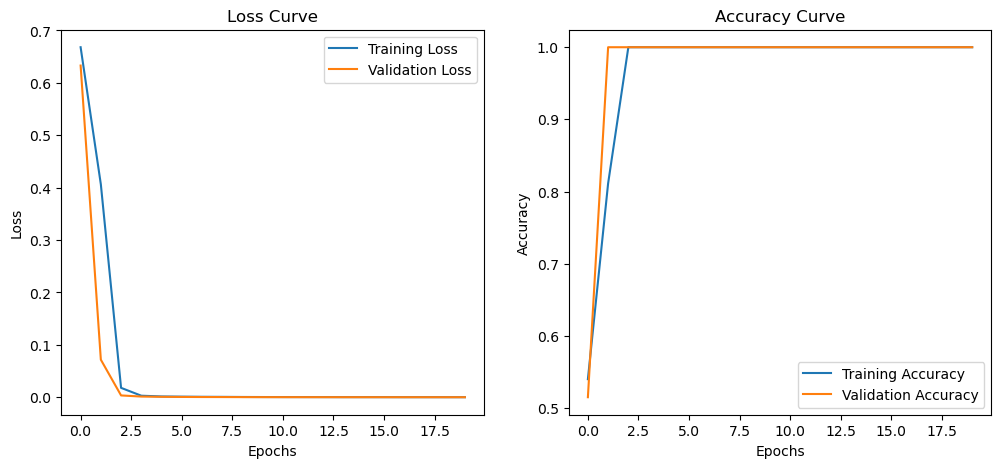

In [27]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()


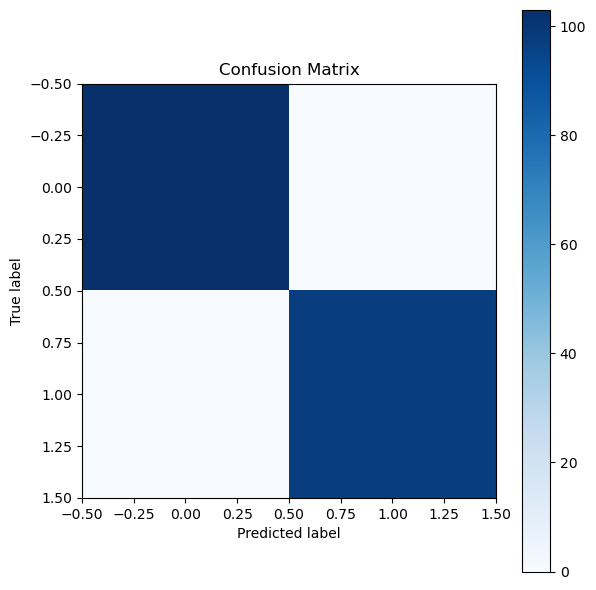

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       103
           1       1.00      1.00      1.00        97

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [28]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


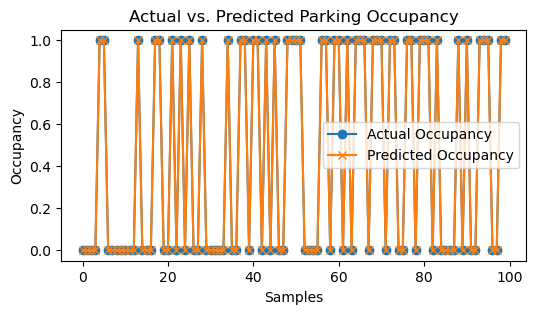

In [30]:
# Plot actual vs predicted values
plt.figure(figsize=(6, 3))
plt.plot(y_test[:100], label='Actual Occupancy', marker='o')
plt.plot(y_pred[:100], label='Predicted Occupancy', marker='x')
plt.xlabel('Samples')
plt.ylabel('Occupancy')
plt.legend()
plt.title('Actual vs. Predicted Parking Occupancy')
plt.show()



### As can be seen above F1-Score, Accuracy, Prediction and Recall of 100% 
### Achieved using LSTM for prediction of Occupancy Status using Feature Engineered Dataset